In [51]:
# Import libraries
import tarfile
import scanpy as sc
import os
import anndata as ad

In [52]:
# Read sample 1 and sample 2 from endometrsiosis
data_dir = "/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/data/Endometriosis"
adata_1 = sc.read_10x_mtx(
        data_dir,
        prefix="GSM6605431_EMS1_",
        var_names='gene_symbols',
        make_unique=True,
        cache=True
    )
adata_2 = sc.read_10x_mtx(
        data_dir,
        prefix="GSM6605432_EMS2_",
        var_names='gene_symbols',
        make_unique=True,
        cache=True
    )

In [53]:
def preprocess(adata):
    # Basic filtering
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    # Annotate mito genes and filter them 
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
    # Normalize
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Logarithmize
    sc.pp.log1p(adata)
    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata = adata[:, adata.var.highly_variable]
    # Scale
    sc.pp.scale(adata, max_value=10)    
    # PCA
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(
        adata,
        resolution=0.25,
        random_state=0
    )
    sc.tl.umap(adata)
    return adata

In [54]:
adata_1 = preprocess(adata_1)

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/saidalkildani/.pyenv/versions/3.11.3/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [55]:
adata_1

AnnData object with n_obs × n_vars = 4067 × 3996
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

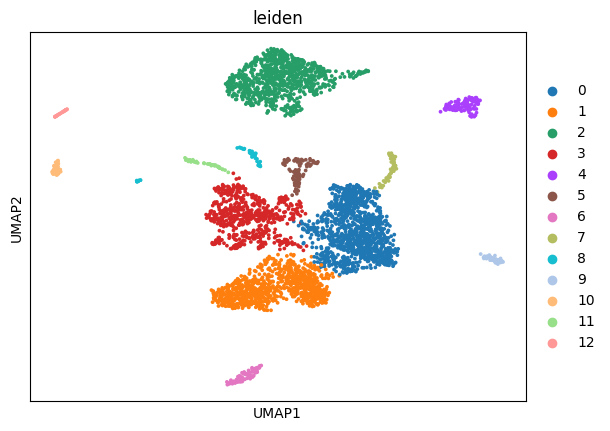

In [56]:
sc.pl.umap(adata_1, color="leiden")

In [57]:
adata_2 = preprocess(adata_2)

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/saidalkildani/.pyenv/versions/3.11.3/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


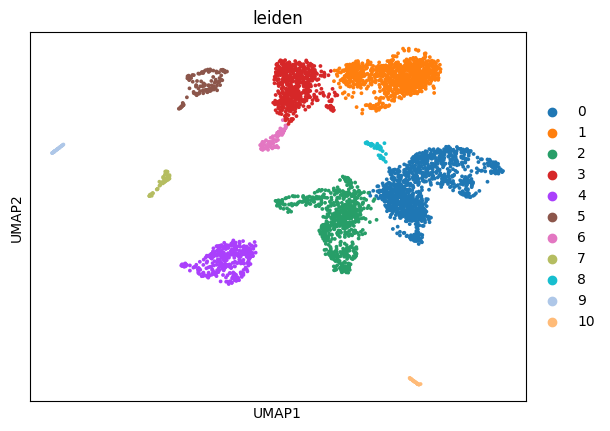

In [58]:
sc.pl.umap(adata_2, color="leiden")

In [67]:
#Overlap features
var_names = adata_1.var_names.intersection(adata_2.var_names)
len(var_names)
adata_1 = adata_1[:,var_names]
adata_2 = adata_2[:,var_names]

In [68]:
sc.tl.ingest(adata_1, adata_2, obs='leiden')

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
<frozen _collections_abc>:949: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.


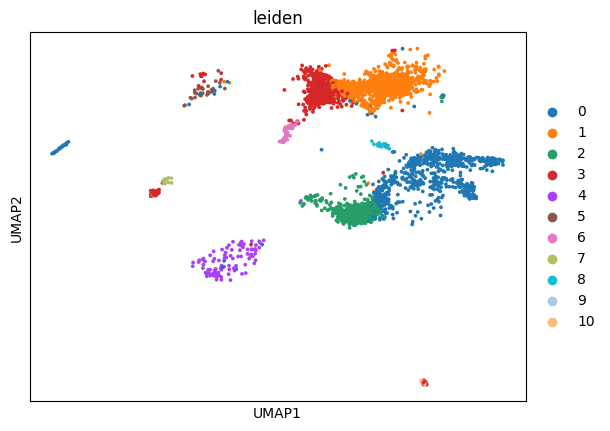

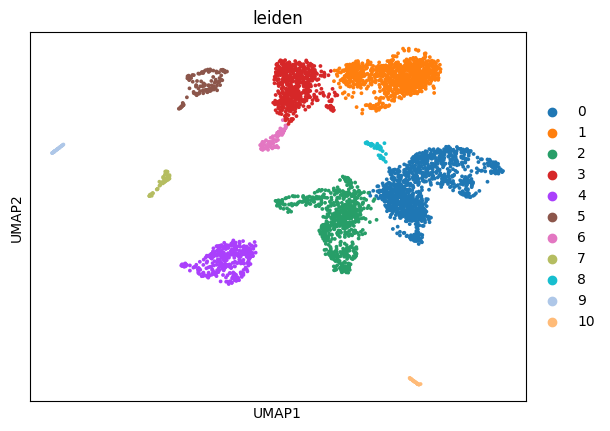

In [69]:
sc.pl.umap(adata_1, color= ["leiden"])
sc.pl.umap(adata_2, color= ["leiden"])

# Pre-integration

In [2]:
# For loop to create an adata for the cancer dataset
# Extract files to a directory
data_dir = "/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/data/Cancer"
with tarfile.open("data/Cancer/GSE184880_RAW.tar", "r") as tar:
    tar.extractall(path="data/Cancer")
# List all prefixes (one per sample)
prefixes = [
    "GSM5599220_Norm1",
    "GSM5599221_Norm2",
    "GSM5599222_Norm3",
    "GSM5599223_Norm4",
    "GSM5599224_Norm5",
    "GSM5599225_Cancer1",
    "GSM5599226_Cancer2",
    "GSM5599227_Cancer3",
    "GSM5599228_Cancer4",
    "GSM5599229_Cancer5",
    "GSM5599230_Cancer6",
    "GSM5599231_Cancer7"
]

adatas = []
for prefix in prefixes:
    # Rename files to match Scanpy's expectations

    os.rename(
        os.path.join(data_dir, f"{prefix}.matrix.mtx.gz"),
        os.path.join(data_dir, f"{prefix}_matrix.mtx.gz")
    )
    os.rename(
        os.path.join(data_dir, f"{prefix}.barcodes.tsv.gz"),
        os.path.join(data_dir, f"{prefix}_barcodes.tsv.gz")
    )
    os.rename(
        os.path.join(data_dir, f"{prefix}.genes.tsv.gz"),
        os.path.join(data_dir, f"{prefix}_features.tsv.gz")
    )
    prefix = prefix + "_" # add underscore 
    adata = sc.read_10x_mtx(
        data_dir,
        prefix=prefix,
        var_names='gene_symbols',
        make_unique=True,
        cache=True
    )
    adata.obs["sample"] = prefix.rstrip("_")
    adatas.append(adata)
# Concatenate all Objects inside adatas into one
adata_cancer = ad.concat(adatas, label="batch", keys=[p.rstrip("_") for p in prefixes])

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# Extract files to a directory
data_dir = "/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/data/Endometriosis"
with tarfile.open("data/Endometriosis/GSE214411_RAW.tar", "r") as tar:
    tar.extractall(path="data/Endometriosis")
# List all prefixes (one per sample)
prefixes = [
    "GSM6605431_EMS1_",
    "GSM6605432_EMS2_",
    "GSM6605433_EMS3_",
    "GSM6605434_EMS4_",
    "GSM6605435_EMS5_",
    "GSM6605436_EMS6_",
    "GSM6605437_N1_",
    "GSM6605438_N2_",
    "GSM6605439_N3_",
    "GSM6605440_N4_",
    "GSM7277296_N-5_",
    "GSM7277297_N-6_",
    "GSM7277298_N-7_"
]

adatas = []
for prefix in prefixes:
    adata = sc.read_10x_mtx(
        data_dir,
        prefix=prefix,
        var_names='gene_symbols',
        make_unique=True,
        cache=True
    )
    adata.obs["sample"] = prefix.rstrip("_")
    adatas.append(adata)
# Concatenate all Objects inside adatas into one
adata_endo = ad.concat(adatas, label="batch", keys=[p.rstrip("_") for p in prefixes])

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
def preprocess(adata):
    # Basic filtering
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    # Annotate mito genes and filter them 
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
    # Normalize
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Logarithmize
    sc.pp.log1p(adata)
    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata = adata[:, adata.var.highly_variable]
    return adata

In [ ]:
def vis_umap(adata, x):
    # Scale
    sc.pp.scale(adata, max_value=10)    
    # PCA
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(
        adata,
        resolution=0.25,
        random_state=0
    )
    return sc.tl.umap(adata, color= x)

In [6]:
# Highly variable genes
adata_cancer = preprocess(adata_cancer)
adata_endo = preprocess(adata_endo)

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 

In [84]:
# Merge the two datasets
merged_adata = ad.concat(
    [adata_endo, adata_cancer],
    axis=0,          # Concatenate along cells 
    join="outer",    # Keep all genes only
    keys=["Endometriosis", "Cancer"],
    merge="unique",  # Handle overlapping metadata uniquely
    index_unique="-",  # Avoid duplicate observation names
    fill_value=0     # Fill missing values wth zeros
)

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [40]:
# Assign datasets as a column
merged_adata.obs['dataset'] = merged_adata.obs.index.str.split('-').str[-1]

Epoch 1/90:   0%|          | 0/90 [05:06<?, ?it/s]


In [ ]:
# Visualise
# Scale
sc.pp.scale(merged_adata, max_value=10)    
# PCA
sc.tl.pca(merged_adata, svd_solver="arpack")
sc.pp.neighbors(merged_adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(
    merged_adata,
    resolution=0.25,
    random_state=0
    )
sc.tl.umap(merged_adata)

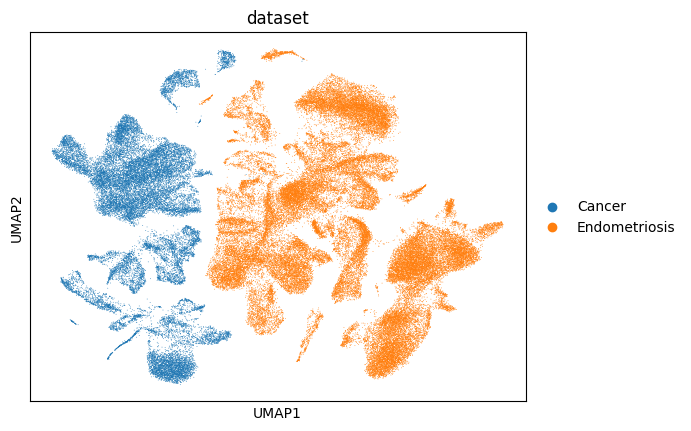

In [11]:
sc.pl.umap(merged_adata, color=["dataset"])

# scVI Integration

In [13]:
import scvi

In [41]:
# Assign counts as a layer
merged_adata.layers["counts"] = merged_adata.X

In [42]:
# Setup model and train
scvi.model.SCVI.setup_anndata(merged_adata, layer="counts", 
                              categorical_covariate_keys= ["sample", "dataset"], # choosing sample as a covariate as we saw in the example above sample-to-sample technical variance
                              continuous_covariate_keys= ["pct_counts_mt", "total_counts"])

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [43]:
model = scvi.model.SCVI(merged_adata)

In [44]:
model.train(accelerator="gpu")

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 1/90:   0%|          | 0/90 [00:00<?, ?it/s]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 2/90:   1%|          | 1/90 [00:21<32:03, 21.61s/it, v_num=1, train_loss_step=502, train_loss_epoch=548]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 3/90:   2%|▏         | 2/90 [00:43<32:17, 22.02s/it, v_num=1, train_loss_step=518, train_loss_epoch=481]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 4/90:   3%|▎         | 3/90 [01:04<30:41, 21.16s/it, v_num=1, train_loss_step=452, train_loss_epoch=469]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 5/90:   4%|▍         | 4/90 [01:24<30:08, 21.02s/it, v_num=1, train_loss_step=478, train_loss_epoch=462]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 6/90:   6%|▌         | 5/90 [01:44<28:55, 20.42s/it, v_num=1, train_loss_step=462, train_loss_epoch=458]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 7/90:   7%|▋         | 6/90 [02:03<27:58, 19.98s/it, v_num=1, train_loss_step=474, train_loss_epoch=455]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 8/90:   8%|▊         | 7/90 [02:22<27:15, 19.70s/it, v_num=1, train_loss_step=458, train_loss_epoch=452]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 9/90:   9%|▉         | 8/90 [02:41<26:31, 19.40s/it, v_num=1, train_loss_step=473, train_loss_epoch=451]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 10/90:  10%|█         | 9/90 [03:00<25:56, 19.22s/it, v_num=1, train_loss_step=434, train_loss_epoch=449]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 11/90:  11%|█         | 10/90 [03:18<25:26, 19.08s/it, v_num=1, train_loss_step=447, train_loss_epoch=448]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 12/90:  12%|█▏        | 11/90 [03:37<25:04, 19.05s/it, v_num=1, train_loss_step=458, train_loss_epoch=447]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 13/90:  13%|█▎        | 12/90 [03:56<24:30, 18.85s/it, v_num=1, train_loss_step=476, train_loss_epoch=446]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 14/90:  14%|█▍        | 13/90 [04:14<23:58, 18.68s/it, v_num=1, train_loss_step=461, train_loss_epoch=445]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 15/90:  16%|█▌        | 14/90 [04:33<23:45, 18.76s/it, v_num=1, train_loss_step=440, train_loss_epoch=444]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 16/90:  17%|█▋        | 15/90 [04:51<23:20, 18.67s/it, v_num=1, train_loss_step=466, train_loss_epoch=444]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 17/90:  18%|█▊        | 16/90 [05:10<22:52, 18.54s/it, v_num=1, train_loss_step=446, train_loss_epoch=443]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 18/90:  19%|█▉        | 17/90 [05:28<22:35, 18.58s/it, v_num=1, train_loss_step=455, train_loss_epoch=443]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 19/90:  20%|██        | 18/90 [05:47<22:15, 18.55s/it, v_num=1, train_loss_step=439, train_loss_epoch=442]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 20/90:  21%|██        | 19/90 [06:05<21:56, 18.54s/it, v_num=1, train_loss_step=410, train_loss_epoch=442]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 21/90:  22%|██▏       | 20/90 [06:24<21:41, 18.59s/it, v_num=1, train_loss_step=439, train_loss_epoch=441]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 22/90:  23%|██▎       | 21/90 [06:42<21:19, 18.54s/it, v_num=1, train_loss_step=423, train_loss_epoch=441]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 23/90:  24%|██▍       | 22/90 [07:01<20:59, 18.52s/it, v_num=1, train_loss_step=415, train_loss_epoch=441]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 24/90:  26%|██▌       | 23/90 [07:19<20:33, 18.42s/it, v_num=1, train_loss_step=445, train_loss_epoch=441]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 25/90:  27%|██▋       | 24/90 [07:38<20:20, 18.50s/it, v_num=1, train_loss_step=424, train_loss_epoch=440]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 26/90:  28%|██▊       | 25/90 [07:57<20:10, 18.62s/it, v_num=1, train_loss_step=469, train_loss_epoch=440]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 27/90:  29%|██▉       | 26/90 [08:15<19:46, 18.53s/it, v_num=1, train_loss_step=445, train_loss_epoch=440]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 28/90:  30%|███       | 27/90 [08:34<19:31, 18.59s/it, v_num=1, train_loss_step=437, train_loss_epoch=440]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 29/90:  31%|███       | 28/90 [08:52<19:09, 18.54s/it, v_num=1, train_loss_step=441, train_loss_epoch=440]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 30/90:  32%|███▏      | 29/90 [09:11<18:47, 18.49s/it, v_num=1, train_loss_step=449, train_loss_epoch=439]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 31/90:  33%|███▎      | 30/90 [09:29<18:32, 18.54s/it, v_num=1, train_loss_step=444, train_loss_epoch=439]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 32/90:  34%|███▍      | 31/90 [09:48<18:10, 18.49s/it, v_num=1, train_loss_step=443, train_loss_epoch=439]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 33/90:  36%|███▌      | 32/90 [10:06<17:50, 18.45s/it, v_num=1, train_loss_step=419, train_loss_epoch=439]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 34/90:  37%|███▋      | 33/90 [10:25<17:37, 18.55s/it, v_num=1, train_loss_step=450, train_loss_epoch=439]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 35/90:  38%|███▊      | 34/90 [10:43<17:15, 18.49s/it, v_num=1, train_loss_step=412, train_loss_epoch=439]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 36/90:  39%|███▉      | 35/90 [11:01<16:55, 18.47s/it, v_num=1, train_loss_step=453, train_loss_epoch=439]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 37/90:  40%|████      | 36/90 [11:20<16:36, 18.44s/it, v_num=1, train_loss_step=445, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 38/90:  41%|████      | 37/90 [11:39<16:25, 18.60s/it, v_num=1, train_loss_step=476, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 39/90:  42%|████▏     | 38/90 [11:57<16:02, 18.50s/it, v_num=1, train_loss_step=460, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 40/90:  43%|████▎     | 39/90 [12:15<15:41, 18.45s/it, v_num=1, train_loss_step=468, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 41/90:  44%|████▍     | 40/90 [12:34<15:30, 18.61s/it, v_num=1, train_loss_step=427, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 42/90:  46%|████▌     | 41/90 [12:58<16:19, 19.98s/it, v_num=1, train_loss_step=454, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 43/90:  47%|████▋     | 42/90 [13:18<16:04, 20.10s/it, v_num=1, train_loss_step=416, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 44/90:  48%|████▊     | 43/90 [13:39<15:54, 20.31s/it, v_num=1, train_loss_step=424, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 45/90:  49%|████▉     | 44/90 [13:59<15:34, 20.32s/it, v_num=1, train_loss_step=444, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 46/90:  50%|█████     | 45/90 [14:20<15:25, 20.57s/it, v_num=1, train_loss_step=439, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 47/90:  51%|█████     | 46/90 [14:40<14:47, 20.18s/it, v_num=1, train_loss_step=434, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 48/90:  52%|█████▏    | 47/90 [14:59<14:17, 19.94s/it, v_num=1, train_loss_step=431, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 49/90:  53%|█████▎    | 48/90 [15:18<13:47, 19.69s/it, v_num=1, train_loss_step=431, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 50/90:  54%|█████▍    | 49/90 [15:38<13:34, 19.87s/it, v_num=1, train_loss_step=492, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 51/90:  56%|█████▌    | 50/90 [15:58<13:11, 19.78s/it, v_num=1, train_loss_step=432, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 52/90:  57%|█████▋    | 51/90 [16:17<12:44, 19.61s/it, v_num=1, train_loss_step=468, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 53/90:  58%|█████▊    | 52/90 [16:36<12:19, 19.45s/it, v_num=1, train_loss_step=408, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 54/90:  59%|█████▉    | 53/90 [16:55<11:52, 19.26s/it, v_num=1, train_loss_step=443, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 55/90:  60%|██████    | 54/90 [17:14<11:27, 19.11s/it, v_num=1, train_loss_step=433, train_loss_epoch=438]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 56/90:  61%|██████    | 55/90 [17:33<11:07, 19.06s/it, v_num=1, train_loss_step=451, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 57/90:  62%|██████▏   | 56/90 [17:52<10:47, 19.04s/it, v_num=1, train_loss_step=440, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 58/90:  63%|██████▎   | 57/90 [18:11<10:26, 18.97s/it, v_num=1, train_loss_step=464, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 59/90:  64%|██████▍   | 58/90 [18:30<10:15, 19.24s/it, v_num=1, train_loss_step=431, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 60/90:  66%|██████▌   | 59/90 [18:49<09:54, 19.17s/it, v_num=1, train_loss_step=455, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 61/90:  67%|██████▋   | 60/90 [19:08<09:31, 19.06s/it, v_num=1, train_loss_step=453, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 62/90:  68%|██████▊   | 61/90 [19:27<09:12, 19.05s/it, v_num=1, train_loss_step=441, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 63/90:  69%|██████▉   | 62/90 [19:48<09:08, 19.59s/it, v_num=1, train_loss_step=448, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 64/90:  70%|███████   | 63/90 [20:08<08:52, 19.74s/it, v_num=1, train_loss_step=433, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 65/90:  71%|███████   | 64/90 [20:28<08:30, 19.65s/it, v_num=1, train_loss_step=464, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 66/90:  72%|███████▏  | 65/90 [20:49<08:24, 20.17s/it, v_num=1, train_loss_step=451, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 67/90:  73%|███████▎  | 66/90 [21:09<08:03, 20.17s/it, v_num=1, train_loss_step=421, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 68/90:  74%|███████▍  | 67/90 [21:28<07:37, 19.88s/it, v_num=1, train_loss_step=450, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 69/90:  76%|███████▌  | 68/90 [21:47<07:11, 19.59s/it, v_num=1, train_loss_step=426, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 70/90:  77%|███████▋  | 69/90 [22:06<06:44, 19.28s/it, v_num=1, train_loss_step=440, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 71/90:  78%|███████▊  | 70/90 [22:25<06:24, 19.21s/it, v_num=1, train_loss_step=464, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 72/90:  79%|███████▉  | 71/90 [22:44<06:03, 19.13s/it, v_num=1, train_loss_step=415, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 73/90:  80%|████████  | 72/90 [23:03<05:42, 19.05s/it, v_num=1, train_loss_step=427, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 74/90:  81%|████████  | 73/90 [23:22<05:23, 19.04s/it, v_num=1, train_loss_step=422, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 75/90:  82%|████████▏ | 74/90 [23:40<05:03, 18.95s/it, v_num=1, train_loss_step=432, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 76/90:  83%|████████▎ | 75/90 [23:59<04:44, 18.96s/it, v_num=1, train_loss_step=451, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 77/90:  84%|████████▍ | 76/90 [24:18<04:25, 18.96s/it, v_num=1, train_loss_step=410, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 78/90:  86%|████████▌ | 77/90 [24:37<04:06, 18.99s/it, v_num=1, train_loss_step=400, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 79/90:  87%|████████▋ | 78/90 [24:57<03:48, 19.05s/it, v_num=1, train_loss_step=411, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 80/90:  88%|████████▊ | 79/90 [25:16<03:29, 19.01s/it, v_num=1, train_loss_step=430, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 81/90:  89%|████████▉ | 80/90 [25:40<03:26, 20.62s/it, v_num=1, train_loss_step=435, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 82/90:  90%|█████████ | 81/90 [27:03<05:55, 39.46s/it, v_num=1, train_loss_step=451, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 83/90:  91%|█████████ | 82/90 [27:23<04:28, 33.51s/it, v_num=1, train_loss_step=448, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 84/90:  92%|█████████▏| 83/90 [27:45<03:29, 29.94s/it, v_num=1, train_loss_step=444, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 85/90:  93%|█████████▎| 84/90 [28:04<02:40, 26.77s/it, v_num=1, train_loss_step=413, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 86/90:  94%|█████████▍| 85/90 [28:23<02:01, 24.31s/it, v_num=1, train_loss_step=423, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 87/90:  96%|█████████▌| 86/90 [28:41<01:29, 22.47s/it, v_num=1, train_loss_step=440, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 88/90:  97%|█████████▋| 87/90 [28:59<01:03, 21.21s/it, v_num=1, train_loss_step=435, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 89/90:  98%|█████████▊| 88/90 [29:17<00:40, 20.29s/it, v_num=1, train_loss_step=455, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 90/90:  99%|█████████▉| 89/90 [29:36<00:19, 19.77s/it, v_num=1, train_loss_step=414, train_loss_epoch=437]

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 90/90: 100%|██████████| 90/90 [29:54<00:00, 19.33s/it, v_num=1, train_loss_step=391, train_loss_epoch=437]

`Trainer.fit` stopped: `max_epochs=90` reached.


Epoch 90/90: 100%|██████████| 90/90 [29:54<00:00, 19.94s/it, v_num=1, train_loss_step=391, train_loss_epoch=437]


In [45]:
latent = model.get_latent_representation()

In [46]:
normalised = model.get_normalized_expression(library_size=1e4) # what we will eventually use for our model

In [47]:
merged_adata.obsm["X_scVI"] = latent

In [48]:
# Visualise   
sc.pp.neighbors(merged_adata, use_rep="X_scVI")
sc.tl.leiden(
    merged_adata,
    resolution=0.25,
    random_state=0
    )
sc.tl.umap(merged_adata)

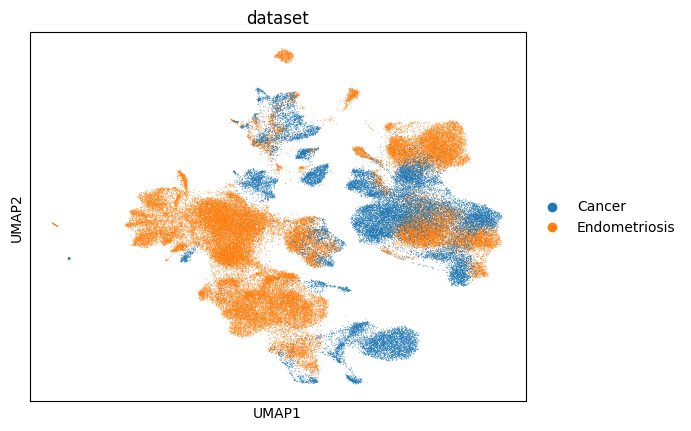

In [50]:
sc.pl.umap(merged_adata, color=["dataset"])